<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Movie-Studio-Startup---What-movies-should-we-make?" data-toc-modified-id="Movie-Studio-Startup---What-movies-should-we-make?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Movie Studio Startup - What movies should we make?</a></span><ul class="toc-item"><li><span><a href="#Business-Objective" data-toc-modified-id="Business-Objective-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Business Objective</a></span></li><li><span><a href="#Datatset" data-toc-modified-id="Datatset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Datatset</a></span></li><li><span><a href="#Importing-the-data" data-toc-modified-id="Importing-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Importing the data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#movie_basics" data-toc-modified-id="movie_basics-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>movie_basics</a></span></li><li><span><a href="#directors" data-toc-modified-id="directors-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>directors</a></span></li><li><span><a href="#known_for" data-toc-modified-id="known_for-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>known_for</a></span></li><li><span><a href="#movie_akas" data-toc-modified-id="movie_akas-1.4.4"><span class="toc-item-num">1.4.4&nbsp;&nbsp;</span>movie_akas</a></span></li><li><span><a href="#movie_ratings" data-toc-modified-id="movie_ratings-1.4.5"><span class="toc-item-num">1.4.5&nbsp;&nbsp;</span>movie_ratings</a></span></li><li><span><a href="#Revenue" data-toc-modified-id="Revenue-1.4.6"><span class="toc-item-num">1.4.6&nbsp;&nbsp;</span>Revenue</a></span></li></ul></li><li><span><a href="#Sourcing-new-data" data-toc-modified-id="Sourcing-new-data-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Sourcing new data</a></span><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#missing-data" data-toc-modified-id="missing-data-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>missing data</a></span></li><li><span><a href="#time-span" data-toc-modified-id="time-span-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>time span</a></span></li><li><span><a href="#genres" data-toc-modified-id="genres-1.5.4"><span class="toc-item-num">1.5.4&nbsp;&nbsp;</span>genres</a></span></li><li><span><a href="#budgets" data-toc-modified-id="budgets-1.5.5"><span class="toc-item-num">1.5.5&nbsp;&nbsp;</span>budgets</a></span></li><li><span><a href="#creative_type" data-toc-modified-id="creative_type-1.5.6"><span class="toc-item-num">1.5.6&nbsp;&nbsp;</span>creative_type</a></span></li><li><span><a href="#source" data-toc-modified-id="source-1.5.7"><span class="toc-item-num">1.5.7&nbsp;&nbsp;</span>source</a></span></li><li><span><a href="#sequel" data-toc-modified-id="sequel-1.5.8"><span class="toc-item-num">1.5.8&nbsp;&nbsp;</span>sequel</a></span></li><li><span><a href="#revenue" data-toc-modified-id="revenue-1.5.9"><span class="toc-item-num">1.5.9&nbsp;&nbsp;</span>revenue</a></span><ul class="toc-item"><li><span><a href="#total-revenue-by-genre" data-toc-modified-id="total-revenue-by-genre-1.5.9.1"><span class="toc-item-num">1.5.9.1&nbsp;&nbsp;</span>total revenue by genre</a></span></li><li><span><a href="#total-revenue-by-ratings" data-toc-modified-id="total-revenue-by-ratings-1.5.9.2"><span class="toc-item-num">1.5.9.2&nbsp;&nbsp;</span>total revenue by ratings</a></span></li><li><span><a href="#total-revenue-by-creative_type" data-toc-modified-id="total-revenue-by-creative_type-1.5.9.3"><span class="toc-item-num">1.5.9.3&nbsp;&nbsp;</span>total revenue by creative_type</a></span></li><li><span><a href="#total_revenue-by-source" data-toc-modified-id="total_revenue-by-source-1.5.9.4"><span class="toc-item-num">1.5.9.4&nbsp;&nbsp;</span>total_revenue by source</a></span></li><li><span><a href="#total-revenue-by-sequel" data-toc-modified-id="total-revenue-by-sequel-1.5.9.5"><span class="toc-item-num">1.5.9.5&nbsp;&nbsp;</span>total revenue by sequel</a></span></li></ul></li></ul></li><li><span><a href="#Is-there-a-correlation-between-budget-and-box-office-revenue?" data-toc-modified-id="Is-there-a-correlation-between-budget-and-box-office-revenue?-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Is there a correlation between budget and box-office revenue?</a></span></li><li><span><a href="#Adventure-movies" data-toc-modified-id="Adventure-movies-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Adventure movies</a></span><ul class="toc-item"><li><span><a href="#What-are-the-budgets-for-adventure-movies?" data-toc-modified-id="What-are-the-budgets-for-adventure-movies?-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>What are the budgets for adventure movies?</a></span></li><li><span><a href="#How-have-Adventure-movies-performed-over-the-years?" data-toc-modified-id="How-have-Adventure-movies-performed-over-the-years?-1.7.2"><span class="toc-item-num">1.7.2&nbsp;&nbsp;</span>How have <em>Adventure</em> movies performed over the years?</a></span></li><li><span><a href="#Who-is-the-target-audience?" data-toc-modified-id="Who-is-the-target-audience?-1.7.3"><span class="toc-item-num">1.7.3&nbsp;&nbsp;</span>Who is the target audience?</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.7.4"><span class="toc-item-num">1.7.4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#PG-13-rating" data-toc-modified-id="PG-13-rating-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>PG-13 rating</a></span><ul class="toc-item"><li><span><a href="#What-genre-of-movies-are-the-most-successful-in-the-PG-13-category?" data-toc-modified-id="What-genre-of-movies-are-the-most-successful-in-the-PG-13-category?-1.8.1"><span class="toc-item-num">1.8.1&nbsp;&nbsp;</span>What genre of movies are the most successful in the PG-13 category?</a></span></li><li><span><a href="#What-are-budgets-for-Action-movies?" data-toc-modified-id="What-are-budgets-for-Action-movies?-1.8.2"><span class="toc-item-num">1.8.2&nbsp;&nbsp;</span>What are budgets for Action movies?</a></span></li><li><span><a href="#How-have-Action-movies-performed-over-the-years?" data-toc-modified-id="How-have-Action-movies-performed-over-the-years?-1.8.3"><span class="toc-item-num">1.8.3&nbsp;&nbsp;</span>How have <em>Action</em> movies performed over the years?</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.8.4"><span class="toc-item-num">1.8.4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Limitations" data-toc-modified-id="Limitations-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Limitations</a></span></li></ul></li><li><span><a href="#Overall-Conclusions" data-toc-modified-id="Overall-Conclusions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Overall Conclusions</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Appendix</a></span></li></ul></div>

# Movie Studio Startup - What movies should we make?

## Business Objective

To provide a detailed analysis on movies that have done well in the recent past and make recommendations to the client, Microsoft Studios, about the kind of movies and markets they should focus on to ensure maximum success and profitability.

Success of a movie can be defined in a myriad ways: awards, critical acclaim, ratings etc. to name a few. To keep things simple here, the analysis will be focused solely on revenue generated by a movie. The initial goal is to gain a foothold in the industry and establish a baseline before experimenting and taking on riskier ventures.

## Datatset

For movie information, we will be using database file from [IMDB](https://www.imdb.com/): im.db. Following image shows the database structure:

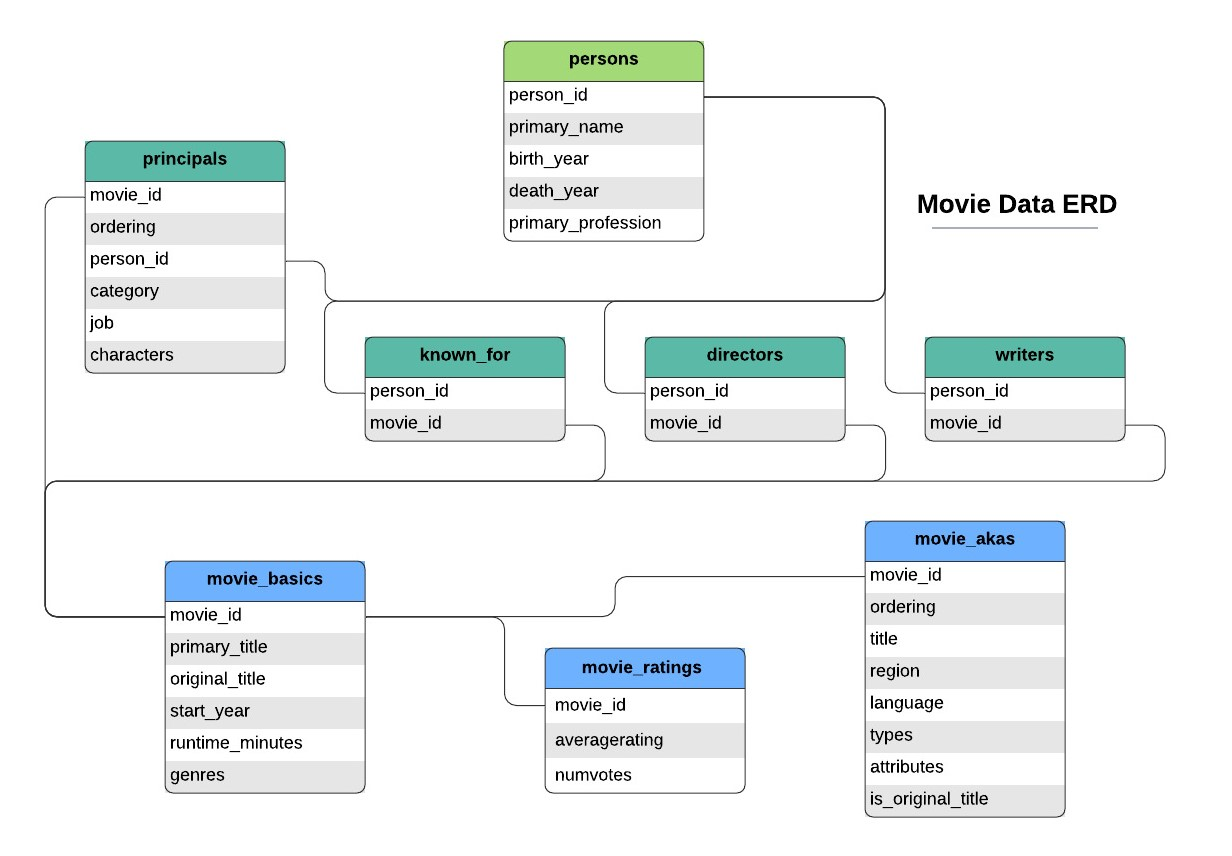

For information about revenue, we will use the **bom.movie_gross.csv** file:

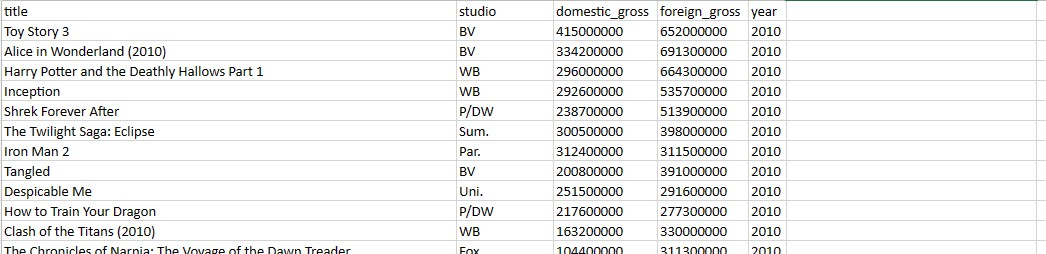

## Importing the data

In [1]:
# import relevant librarires
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # to format the axis
import seaborn as sns
sns.set_style('darkgrid')
import sqlite3
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
#connecting to the db
conn = sqlite3.connect('im.db')

#getting a list of all the tables
tables = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)
tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## EDA

Let's explore each table in the db and see what they look like:

### movie_basics 

Since the **movie_basics** table is the main table, let's start here:

In [3]:
#converting the table into a dataframe
df_movie = pd.read_sql("""SELECT *
                    FROM movie_basics""",conn)
df_movie.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


Like the name suggests, the **movie_basics** lists basic info about each movie like name, release year, genre etc. Also, since the **movie_id** serves as the foreign key in other tables, we will have to join the **movie_basics** table to other tables extract the full information.

In [4]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


Let's check the time period of the data

In [5]:
#grouping the dat by year and using count as the aggregate function
year=df_movie.groupby(df_movie['start_year']).count()
year.head()

,movie_id,primary_title,original_title,runtime_minutes,genres
start_year,,,,,
2010,11849,11849,11849,9986,11452
2011,12900,12900,12900,10707,12432
2012,13787,13787,13786,11405,13356
2013,14709,14709,14708,12308,14298
2014,15589,15589,15589,12964,15095


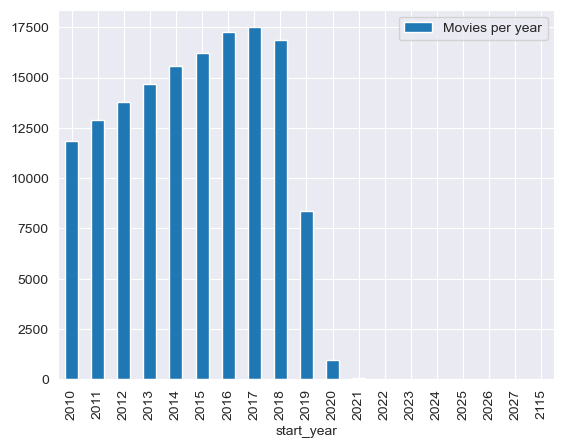

In [6]:
#plotting a histogram to view the distribution of the data
year.plot(kind='bar',y='movie_id',label='Movies per year');

We can see that dataset spans from 2010-2020 with most of the data falling between 2010-2018. We can also see some entries like 2022, 2026 etc. which clearly points to incorrect data. We should remove this from the dataset to potentially skew results.

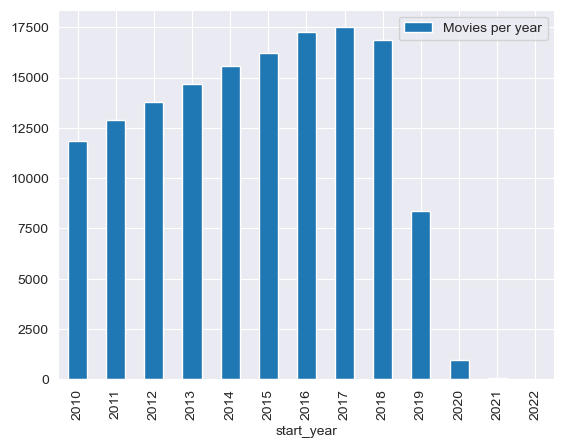

In [7]:
#removing the erroroneous data
df_movie.drop(df_movie[df_movie['start_year'] >= 2023].index,inplace=True)

#verifying that the the rows have been removed
year=df_movie.groupby(df_movie['start_year']).count()
year.plot(kind='bar',y='movie_id',label='Movies per year');

We can see that the wrong entries have been removed.

Next, let's check for missing data:

In [8]:
#checking for missing data
df_movie.isna().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31728
genres              5405
dtype: int64

We can see that in 21 cases, the title of the movie is missing. This is not really a concern, since we're only interested in attributes of the movie like revenue, director etc. we have the information in the other tables. On the other hand, the genres column is critical information that tells us that kind of movies that are successful. Let's fill in the missing information as 'Missing' and for now. For the runtime_minutes, we can fill in the missing information using the medial value.

In [9]:
#filling the missing data for runtime_minutes using the median value
df_movie['runtime_minutes'].fillna(df_movie['runtime_minutes'].median(),inplace=True)

#filling the missing data for genres with 'MISSING'
df_movie['genres'].fillna('missing',inplace=True)

#filling the missing data for original_title with 'MISSING'
df_movie['original_title'].fillna('missing',inplace=True)

In [10]:
#verifying that we have no more missing data
df_movie.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

### directors

In [11]:
df_directors = pd.read_sql("""SELECT *
                              FROM directors""",conn)
df_directors.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


The **directors** table only lists the the id of the director and the movie which will be useful to plot total revenue by each director.

In [12]:
df_directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


Although there is no missing data, we can see that there is more information about directors i.e. 291,174 rows compared to the **movie_basics** table which has only 146,133 rows. We will have to ascertain whether this might be useful or not for our analysis.

### known_for

In [13]:
df_known = pd.read_sql("""SELECT *
                          FROM known_for""", conn)
df_known.head()

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534


The **known_for** table could be talking about the lead actor or actress in each movie.

In [14]:
df_known.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638260 entries, 0 to 1638259
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   person_id  1638260 non-null  object
 1   movie_id   1638260 non-null  object
dtypes: object(2)
memory usage: 25.0+ MB


Similar to the **directors** table, there is far more information provided here i.e 1,638,260 rows(!) compared to the **movie_basics** & the **directors** table. Moving on to the next table...

### movie_akas

In [15]:
df_akas = pd.read_sql("""SELECT *
                         FROM movie_akas""",conn)
df_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


The **movie_akas** table lists information like the language of the movie and the country it was released which could be useful when we try to gather revenue details by region and language. 

In [16]:
df_akas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


The table seems quite chaotic with lots of missing data in more than a few columns. It also now looks like the mismatch with  **movie_basics** table runs thru the dataset. It is quite apparent that this is not good quality data and we will need to work with better data to provide better recommendations.

In [17]:
#checking for missing data
df_akas.isna().sum()

movie_id                  0
ordering                  0
title                     0
region                53293
language             289988
types                163256
attributes           316778
is_original_title        25
dtype: int64

Let's examine the columns with missing data more closely:

In [18]:
df_akas.loc[:,['region','language','attributes','types']]

,region,language,attributes,types
0,BG,bg,None,None
1,JP,None,None,imdbDisplay
2,BR,None,None,imdbDisplay
3,BR,None,short title,None
4,FR,None,None,imdbDisplay
...,...,...,...,...
331698,None,None,None,original
331699,XWW,en,None,imdbDisplay
331700,None,None,None,original
331701,ES,None,None,None


Key columns like **region and language** have quite a lot of missing especially in the case of **language**. As we've done before, let's call the missing values as  'missing' and work thru the other tables in the db.

In [19]:
#replacing the missing data 
df_akas.fillna('missing',inplace=True)

#verifying 
df_akas.isna().sum()

movie_id             0
ordering             0
title                0
region               0
language             0
types                0
attributes           0
is_original_title    0
dtype: int64

### movie_ratings

In [20]:
df_ratings = pd.read_sql("""SELECT *
                          FROM movie_ratings""", conn)
df_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


The **movie_ratings** table is straight-forward and provides ratings of each movie.

In [21]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


Looks like the **movie_ratings** table is also the smallest table in the db and hence might not be very useful at all. But, let's have open mind before we disregard it.

### Revenue

As explained earlier, since we're looking at revenue as the main metric of success, we also need to look at the **bom_movie_gross.csv** file and see how we can tie that it in to the rest of the db for our analysis.

In [22]:
#creating a df of the revenue file
df_revenue = pd.DataFrame(pd.read_csv('bom.movie_gross.csv'))
df_revenue.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [23]:
df_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


We have a major problem here. Earlier, we defined success based on gross revenue and since it is now apparent that we have very little of that data available, this make the dataset insufficient for our analysis. Given this fact and combined with the other inadequacies of this dataset, means that we have to look elsewhere for better quality data.

## Sourcing new data

[Opus Data](https://www.opusdata.com/) does have the data that we're looking for. While most of their data is proproetary, they do provide an 'extract' that we can make use of. The file is titled *'MovieData.csv'* which is what we'll use moving forward.

In [24]:
#importing the new csv file
df = pd.read_csv('MovieData.csv')
df.head()

,movie_name,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,rating,creative_type,source,production_method,genre,sequel,running_time
0,Madea's Family Reunion,2006,8220100,10000000,63257940,62581,PG-13,Contemporary Fiction,Based on Play,Live Action,Comedy,1.0,NaN
1,Krrish,2006,58540100,10000000,1430721,31000000,Not Rated,Science Fiction,Original Screenplay,Live Action,Action,1.0,NaN
2,End of the Spear,2006,34620100,10000000,11748661,175380,PG-13,Historical Fiction,Original Screenplay,Live Action,Drama,0.0,NaN
3,A Prairie Home Companion,2006,24910100,10000000,20342852,6373339,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,105.0
4,Saw III,2006,5840100,10000000,80238724,83638091,R,Contemporary Fiction,Original Screenplay,Live Action,Horror,1.0,NaN


In [25]:
#getting info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936 entries, 0 to 1935
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   movie_name                1936 non-null   object 
 1   production_year           1936 non-null   int64  
 2   movie_odid                1936 non-null   int64  
 3   production_budget         1936 non-null   int64  
 4   domestic_box_office       1936 non-null   int64  
 5   international_box_office  1936 non-null   int64  
 6   rating                    1913 non-null   object 
 7   creative_type             1923 non-null   object 
 8   source                    1915 non-null   object 
 9   production_method         1925 non-null   object 
 10  genre                     1926 non-null   object 
 11  sequel                    1934 non-null   float64
 12  running_time              1822 non-null   float64
dtypes: float64(2), int64(5), object(6)
memory usage: 196.8+ KB


Looking at the columns above, we can see we have information about movie budgets and box office revenue for domestic and international markets that are crucial to for our analysis.

### EDA

### missing data

Checking for missing data:

In [26]:
#checking for missing data
df.isna().sum()

movie_name                    0
production_year               0
movie_odid                    0
production_budget             0
domestic_box_office           0
international_box_office      0
rating                       23
creative_type                13
source                       21
production_method            11
genre                        10
sequel                        2
running_time                114
dtype: int64

We can see that except for the *running_time*, the rest of the columns have < 1% of the data missing which means we can either choose to remove the rows and fill them as 'missing' for the categorical data. For *running_time and sequel*, we can impute the median value. The median is more reliable as it is less affected by outliers.

In [27]:
#getting the list of categorical columns
df_cat = df.select_dtypes(include=object)
cats = df_cat.columns

#replcaing the missing values as 'Missing'
for col in cats:
    df[col].fillna('Missing',inplace=True)

    
#imputing median value for running_time
df['running_time'].fillna(df['running_time'].median(),inplace=True)
df['sequel'].fillna(df['sequel'].median(),inplace=True)

#checking for missing data
df.isna().sum()

movie_name                  0
production_year             0
movie_odid                  0
production_budget           0
domestic_box_office         0
international_box_office    0
rating                      0
creative_type               0
source                      0
production_method           0
genre                       0
sequel                      0
running_time                0
dtype: int64

We do not have any more missing data.

Let's check some attribute of the data. We can define a function to simplify things:

In [28]:
def column_name(column):
    col_df = df.groupby(df[column]).count()
    col_df.plot(kind = 'bar',y = 'movie_name',label = f'Movies by {column}')

### time span

Time span of the data:

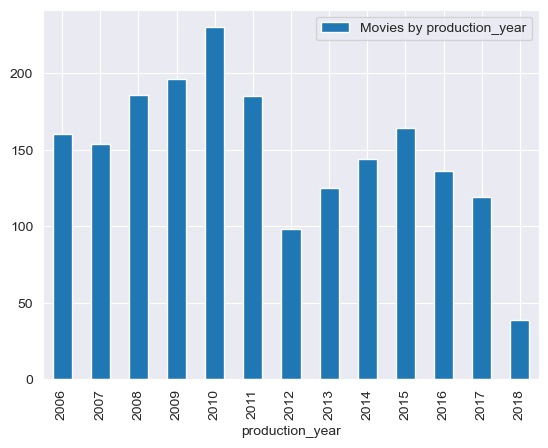

In [29]:
column_name('production_year')

We can see that the data ranges from 2006-2018

### genres

Let's check for the different genres and their representation:

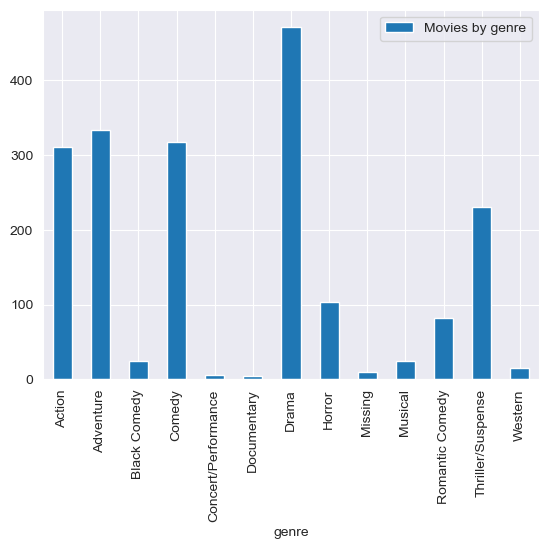

In [30]:
column_name('genre')

We can see that *Drama* ranks the highest amongst movies produced, while *Action,Adventure & Comedy*, though lesser than *Drama* are all almost equally represented.

### budgets

What about budget? What are typical budgets for movies in our dataset?

Let's get some summary statistics about the budget

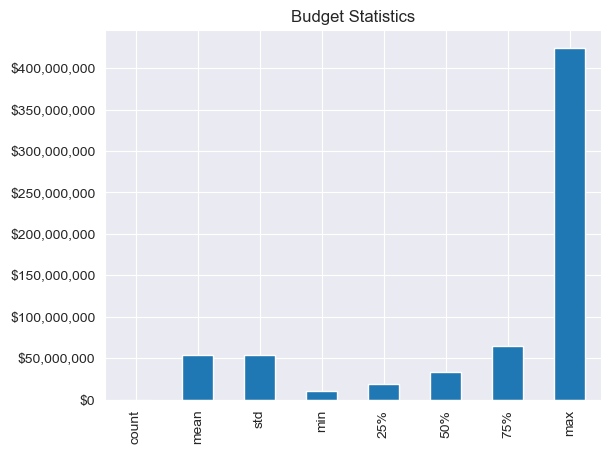

In [31]:
fig,ax=plt.subplots()
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
#plotting the stats
stats = df['production_budget'].describe()
stats.plot(kind='bar',title='Budget Statistics');

We can see that there were movies produced with some eye-watering numbers i.e excess of *400 million USD*. Median budget is approx. *40 million USD* while the least budget is approx. less than *5 million USD*. 

What if we looked at budgets by year? Did budgets of movies increase, decrease or stay the same through the different years?

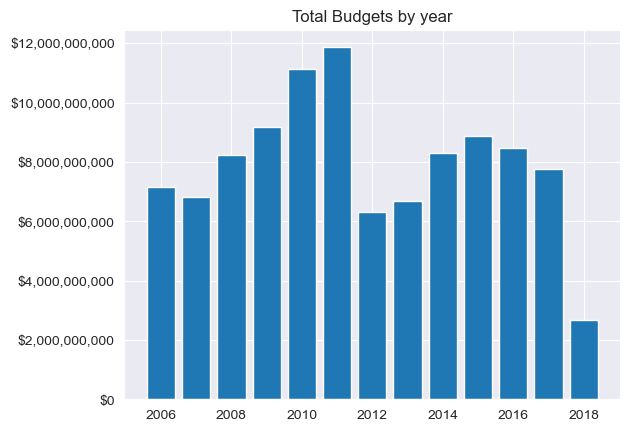

In [32]:
# #grouping movies by year and budgets
budget_years = df.groupby(by=['production_year']).sum()
#plotting
fig,ax=plt.subplots()
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
# getting the sum of the budgets
# budget_years.plot(kind='bar',y='production_budget');
ax.bar(x=budget_years.index,height=budget_years['production_budget']);
ax.set_title('Total Budgets by year');


We can see that between 2006-2011, there is an upward trend, before a drastic fall off in 2012 and then total budgets never recovering to their earlier highs.

### creative_type

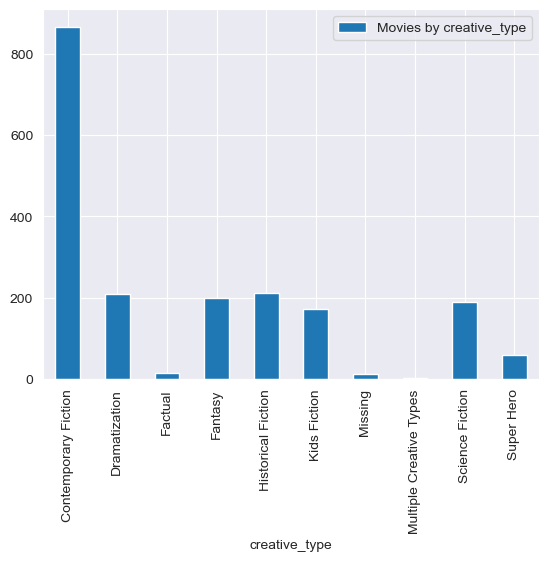

In [33]:
column_name('creative_type')

*Fiction* movies are the highest types of movies that were produced

### source

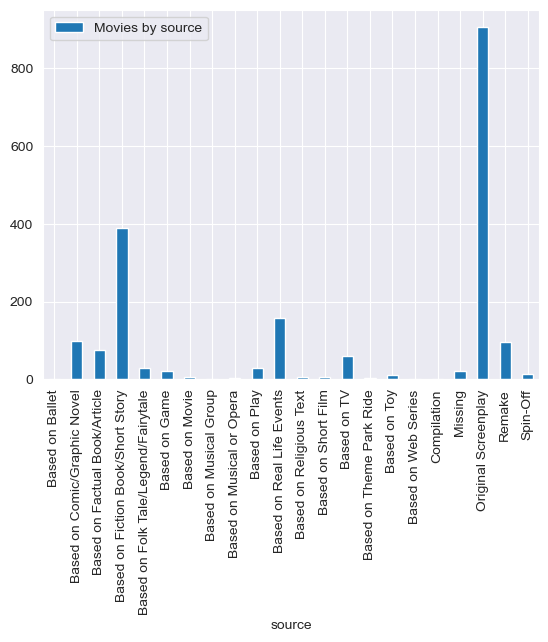

In [34]:
column_name('source')

Most movies that were produced were based on *oiginal_screenplays*. Nearly a third of the movies produced were based on books.

### sequel

Let's replace the sequel values for better understanding

In [35]:
#creating a dictionary of required values
sequel_vals = {0.0:'Original',
               1.0:'Sequel'}

#mapping the values to the df
df['sequel'] = df['sequel'].map(sequel_vals)

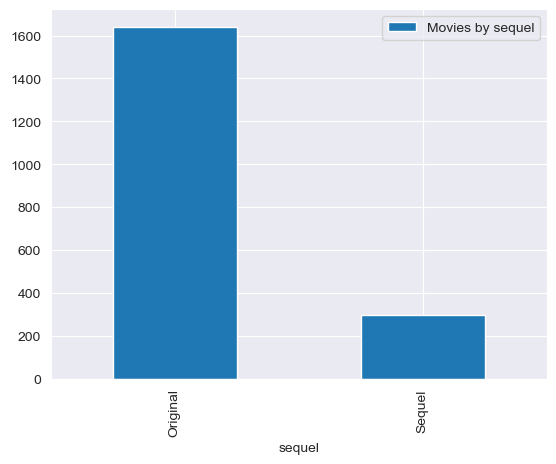

In [36]:
#running the function
column_name('sequel')

*Original* movies outnumber *sequels* by nearly 8 times.

### revenue

There are many different ways we can look at revenue:
1. Total revenue i.e. both international and domestic or each market individually
2. Revenue by genres, rating, budget etc.

For the sake of simplicity, let's look at *total revenue*:

In [37]:
# calculate total_revenue
df['total_revenue'] = df['domestic_box_office'] + df['international_box_office']

We can build a function to look at total revenue using different attributes i.e ratings, genre etc.

In [38]:
def total_revenue(column_name):
    col_df = df.groupby(df[column_name]).sum()
    
    #sort in descending order for easy viz
    col_df.sort_values(by=['total_revenue'],inplace=True,ascending=False)
    
    #plotting
    fig,ax = plt.subplots(figsize=(8,5))
    # to get the dollar sign
    ax.yaxis.set_major_formatter('${x:1.2f}')
    #to get the comma
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    #plotting data
    ax.bar(x=col_df.index,height=col_df['total_revenue'],width=0.3);
    ax.tick_params(axis='x',labelrotation=90,labelsize=10);
    ax.tick_params(axis='y',labelsize=10);
    ax.set_title(f'Total Revenues by {column_name}',{'fontsize':13});

#### total revenue by genre

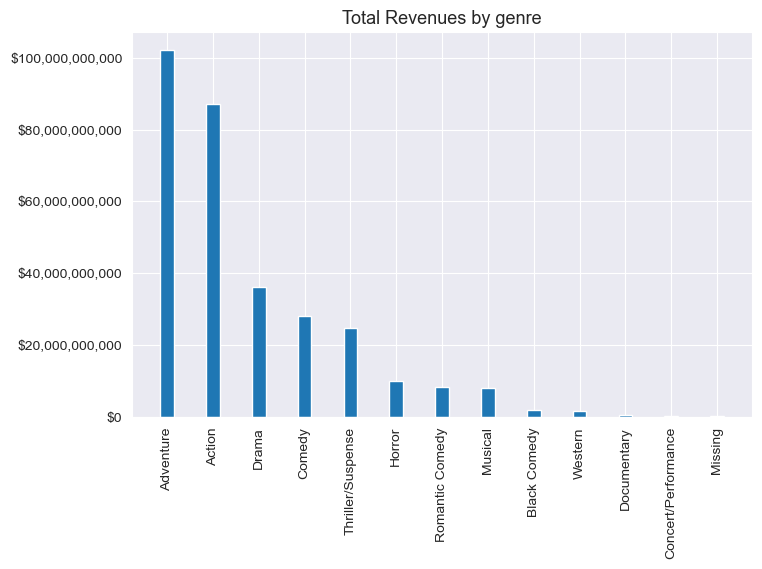

In [39]:
total_revenue('genre')

*Adventure* movies have grossed the highest revenue amongst all the genres produced. It is interesting to note that though *Drama* movies ranked the highest in number of movies made, it only third in terms of revenue; less than half of *Adventure* movies.

#### total revenue by ratings

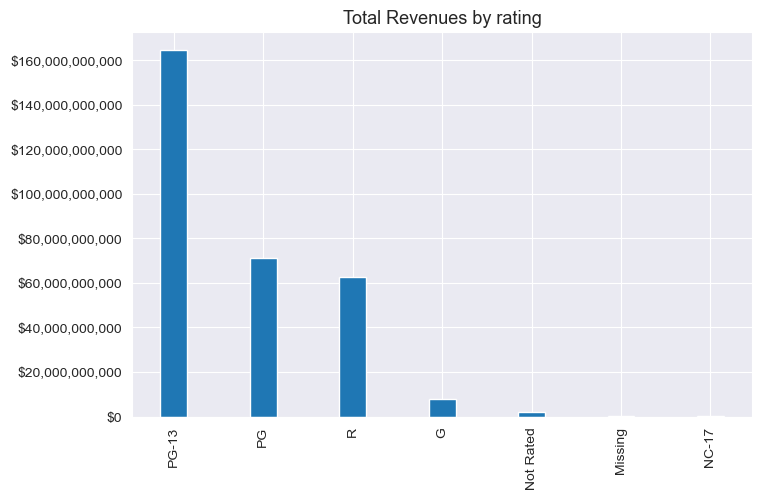

In [40]:
total_revenue('rating')

*PG-13* are by far the most successful movies at the box office outperforming second place *PG* by nearly 3 times over.

#### total revenue by creative_type

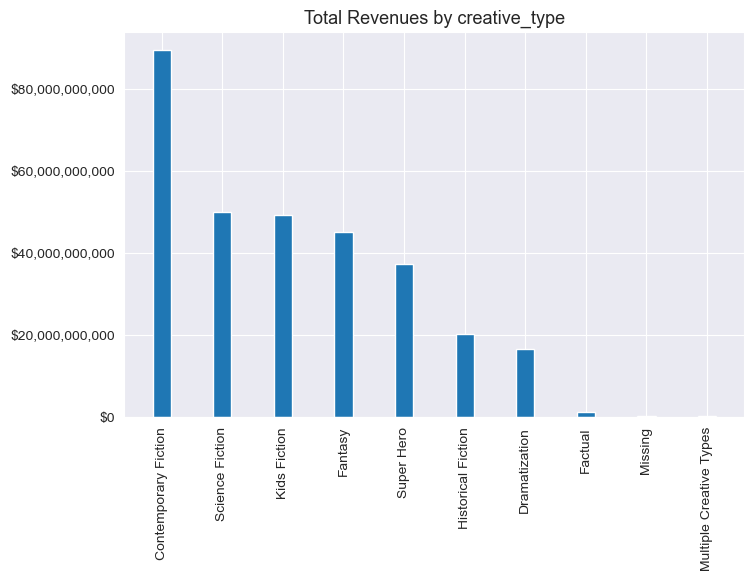

In [41]:
total_revenue('creative_type')

#### total_revenue by source

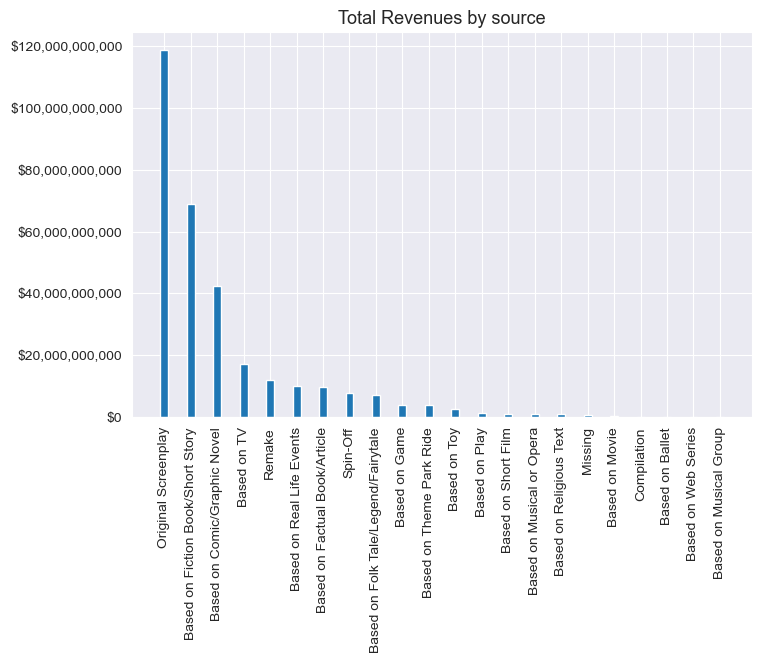

In [42]:
total_revenue('source')

#### total revenue by sequel

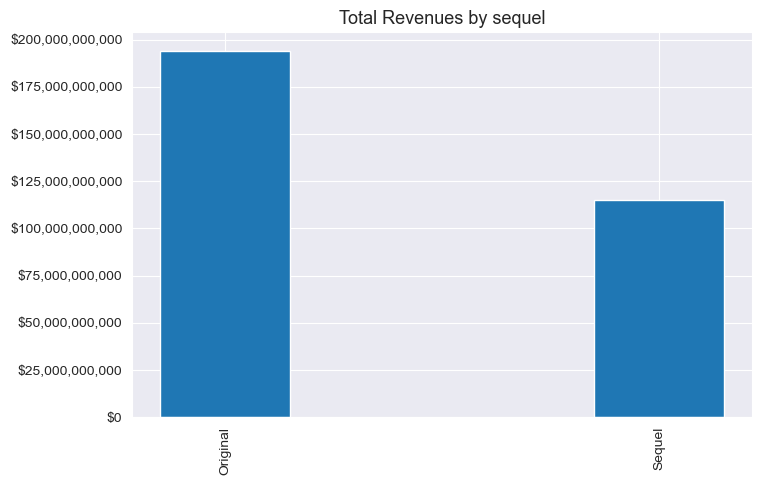

In [43]:
total_revenue('sequel')

## Is there a correlation between budget and box-office revenue?

As a side-bar, let's look to answer the following question: does big budget guarantee big returns? Is simply chucking money an easy way to profits or is there a more nuanced way to producing movies? 

First, let's visualize budget vs revenue using a scatter plot

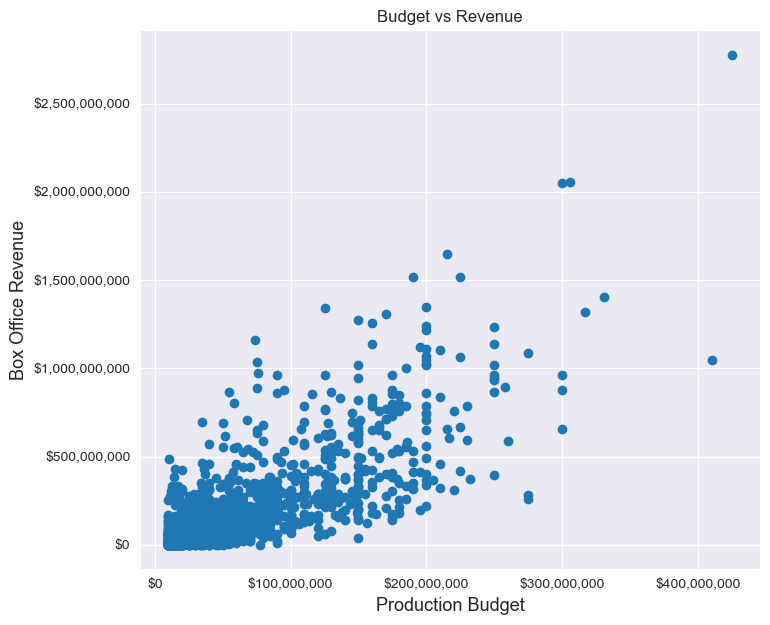

In [44]:
fig,ax=plt.subplots(figsize=(8,7))
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
ax.xaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.xaxis.set_major_formatter(tick)
#plot the data
ax.scatter(x=df['production_budget'],y=df['total_revenue']);
ax.set_xlabel('Production Budget', {'fontsize' : 13});
ax.set_ylabel('Box Office Revenue', {'fontsize' : 13});
ax.set_title('Budget vs Revenue');

It is not immediately apparent if there is a relationship between budget and revenue. We can build a simple linear regression model to test our theory:

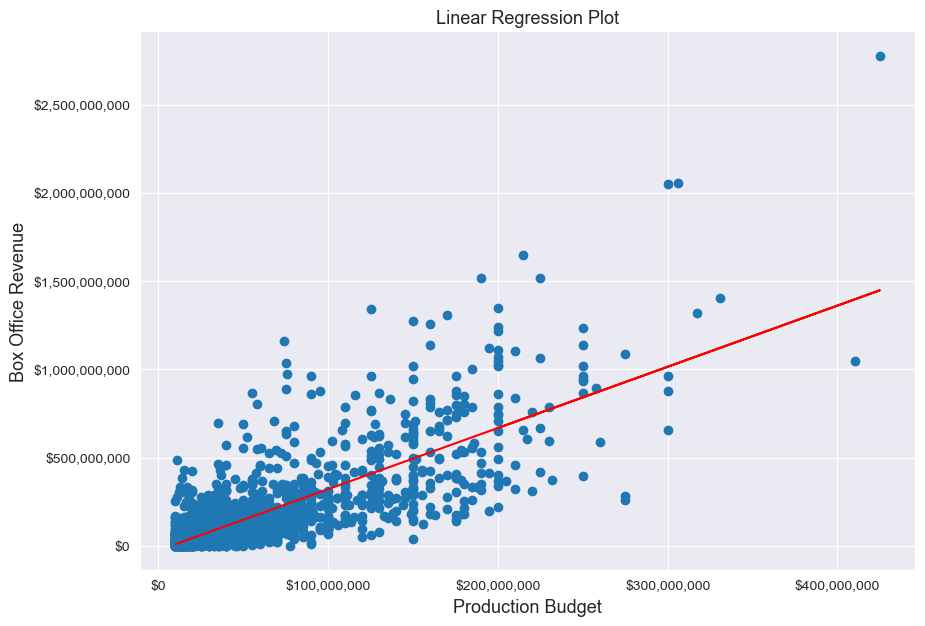

In [45]:
#defining X and Y
x = df['production_budget'].values
y = df['total_revenue'].values

#reshaping x to amke it explict that is a series of observed values for a single feature
x= x.reshape(-1,1)

#instantiate a linear regression model
lr= LinearRegression()

#fitting the model
lr.fit(x,y)

#getting predictions
y_pred = lr.predict(x)

#visualize the plot
fig,ax = plt.subplots(figsize=(10,7))
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
ax.xaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.xaxis.set_major_formatter(tick)
#plotting
ax.scatter(x=df['production_budget'],y=df['total_revenue']);
ax.plot(x,y_pred,c='r');
ax.set_xlabel('Production Budget', {'fontsize' : 13});
ax.set_ylabel('Box Office Revenue', {'fontsize' : 13});
ax.set_title('Linear Regression Plot',{'fontsize' : 13});

We can from the plot that the seems to be able to find a fit. We can quantify model efficiency using the R-squared value.

In [46]:
#importing r-square from sklearn 
r_square = r2_score(y,y_pred)
print(f'R-squared value of the model is {round(r_square,2)}')

R-squared value of the model is 0.61


While we intutively know that big budgets alone do not guarantee similar return, the model suggests that the budget does play a significant factor in movie return i.e. 61%.

Setting aside the regression study, based on what we've seen before,we can conclude the following: 
- *Adventure* movies are the most successful and rank second in terms of movies made.
- *PG-13* should be the target audience.
- *Original Screenplays* guarantee the most success compared to adaptations by book or movies based on real life.


Let's focus on Adventure and PG-13 movies for our analysis.

## Adventure movies

In [47]:
#creating a seprerate df of adventure movies
df_adv = df.loc[df['genre'] == 'Adventure']
df_adv.head()

,movie_name,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,rating,creative_type,source,production_method,genre,sequel,running_time,total_revenue
29,Hoot,2006,40190100,15000000,8117637,107361,PG,Contemporary Fiction,Based on Fiction Book/Short Story,Live Action,Adventure,Original,91.0,8224998
47,Doogal,2006,41200100,20000000,7578946,20479706,G,Kids Fiction,Based on TV,Digital Animation,Adventure,Original,83.0,28058652
62,Unaccompanied Minors,2006,28450100,25000000,16655224,5315607,PG,Contemporary Fiction,Original Screenplay,Live Action,Adventure,Original,87.0,21970831
66,Nanny McPhee,2006,11750100,25000000,47279279,81466299,PG,Fantasy,Based on Fiction Book/Short Story,Live Action,Adventure,Original,99.0,128745578
88,Zoom,2006,34430100,35000000,11989328,516860,PG,Super Hero,Based on Comic/Graphic Novel,Live Action,Adventure,Original,108.0,12506188


### What are the budgets for adventure movies? 

Getting some basic stats of adventure movie budgets:

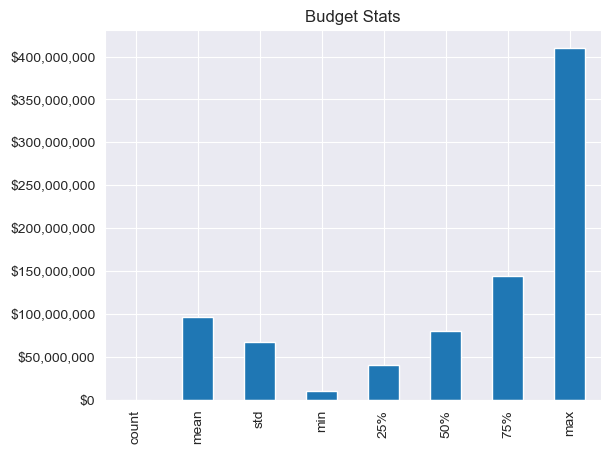

In [48]:
#plotting the data
fig,ax=plt.subplots()
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
#plotting budget stats
budget=df_adv['production_budget'].describe()
budget.plot(kind='bar',title='Budget Stats');

Clearly, we have a few outliers. Since, we're providing recommendations to a start-up, we can safely assume that such lavish amounts will not be spent. Let's assume that $100 million is the maximum that can be spent.

In [49]:
#fitering
high_budget = df_adv.loc[df_adv['production_budget'] > 100000000]

#getting the indices to drop
indices = high_budget.index

#dropping the movies from the dataset
df_adv.drop(index=indices,inplace=True)

Reviewing stats for budgets again:

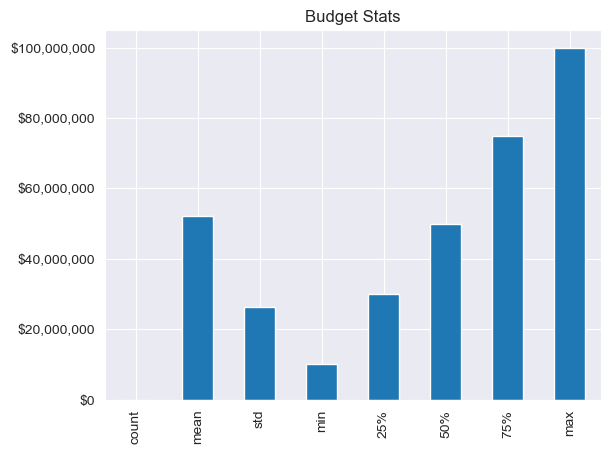

In [50]:
#plotting the data
fig,ax=plt.subplots()
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
#plotting budget stats
budget=df_adv['production_budget'].describe()
budget.plot(kind='bar',title='Budget Stats');

We can see that the average spend on *Adventure* movies is approximately $55 million with the median not being too far off.
The std dev is approx $22 million signifying that there were movies produced with budgets less than $55 million as well. 

**Therefore, the studio should expect to spend around $50 million when making *Adventure* movies**.

### How have *Adventure* movies performed over the years?

We can also check to see if there is a trend in the performance of adventure movies over the years:

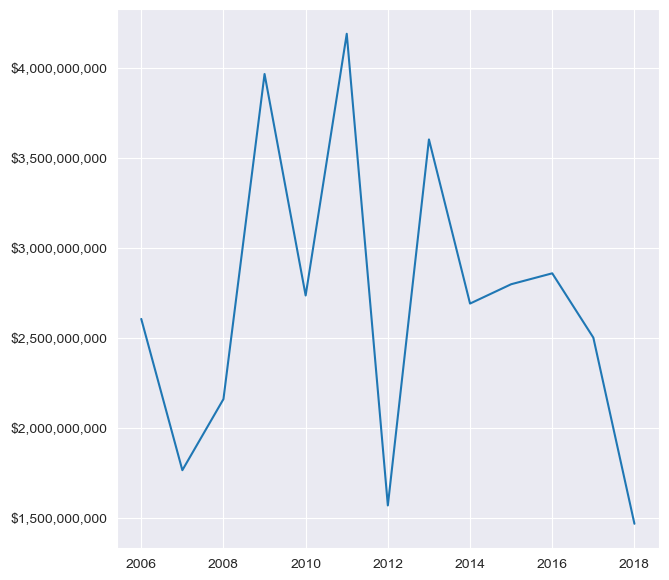

In [51]:
#creating a seperate df
years = df_adv.groupby(df_adv['production_year']).sum()

#plotting 
fig,ax=plt.subplots(figsize=(7,7))
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
#plot the data
ax.plot(years['total_revenue']);

Let's juxtapose this with the number of movies made to see if there's a relation:

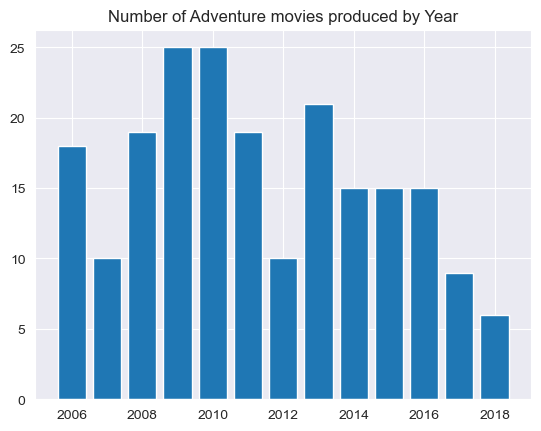

In [52]:
#creating a seperate df
adv_counts = pd.DataFrame(data=df_adv['production_year'].value_counts())

#plotting
fig,ax=plt.subplots()
ax.bar(x=adv_counts.index,height=adv_counts['production_year']);
ax.set_title('Number of Adventure movies produced by Year');

We can see that even during the peak production years of 2009-2010 revenues were inconsistent. Even if we discount 2018 due to lack of data for that particular year, number of *Adventure* movies show a downward trend.

This could also be interpreted as an opportunity: given the dearth of adventure movies, if the studio were to come to out with good movies, they could be very very successful.

### Who is the target audience?

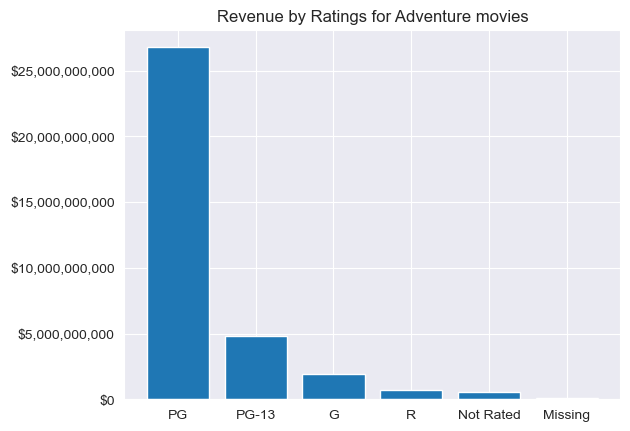

In [53]:
#creating a seperate df
adv_ratings = df_adv.groupby(df_adv['rating']).sum()
#sort revenue in descending order
adv_ratings.sort_values('total_revenue',inplace=True,ascending=False)

#plotting the data
fig,ax=plt.subplots()
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
#plotting budget stats
ax.bar(x=adv_ratings.index,height=adv_ratings['total_revenue']);
ax.set_title('Revenue by Ratings for Adventure movies');

**Target audience for *Adventure* movies should be adults.**

### Conclusion

From the above, we can arrive at the following conclusions about *Adventure* movies:

1. Budget can be expected to be around $50 million.
2. Target audience falls in the *PG* category

## PG-13 rating

Since we established earlier since *PG-13* movies collected the most revenue, let's analyze it now.

In [54]:
#creating a seperate df
df_ratings = df.loc[df['rating'] == 'PG-13']
df_ratings.head()

,movie_name,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,rating,creative_type,source,production_method,genre,sequel,running_time,total_revenue
0,Madea's Family Reunion,2006,8220100,10000000,63257940,62581,PG-13,Contemporary Fiction,Based on Play,Live Action,Comedy,Sequel,108.0,63320521
2,End of the Spear,2006,34620100,10000000,11748661,175380,PG-13,Historical Fiction,Original Screenplay,Live Action,Drama,Original,108.0,11924041
3,A Prairie Home Companion,2006,24910100,10000000,20342852,6373339,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,Original,105.0,26716191
5,Employee of the Month,2006,19540100,10000000,28444855,9920000,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,Original,108.0,38364855
7,Peaceful Warrior,2006,52640100,10000000,2893666,366513,PG-13,Dramatization,Based on Fiction Book/Short Story,Live Action,Drama,Original,108.0,3260179


### What genre of movies are the most successful in the PG-13 category?

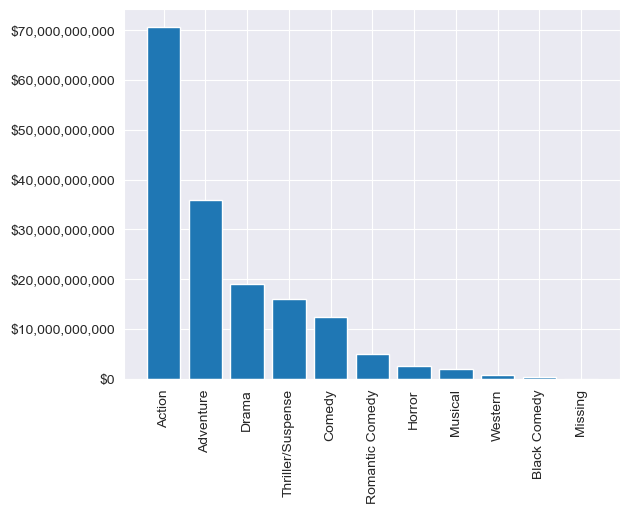

In [55]:
#creating a seperate df
genre_rating = df_ratings.groupby('genre').sum()
#sorting revenue in descending order
genre_rating.sort_values('total_revenue',ascending=False,inplace=True)

#plotting the data
fig,ax=plt.subplots()
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
#plot the data
ax.bar(x=genre_rating.index,height=genre_rating['total_revenue']);
ax.tick_params(axis='x',labelrotation=90)


Not wholly unsuprising that *Action* is the most popular genre in the PG-13 category, which comprises of teenagers.

**Therefore, the studio must look to produce *Action* movies for the PG-13 category.**

### What are budgets for Action movies?

Again, keeping in mind the limitations of a start-up and thereby seetting the max at $100 million, let's look at budgets for action movies:

In [56]:
action_budget = pd.DataFrame(data=df_ratings.loc[df_ratings['production_budget'] < 100000000])
budget_stats=pd.DataFrame(data=action_budget['production_budget'].describe())

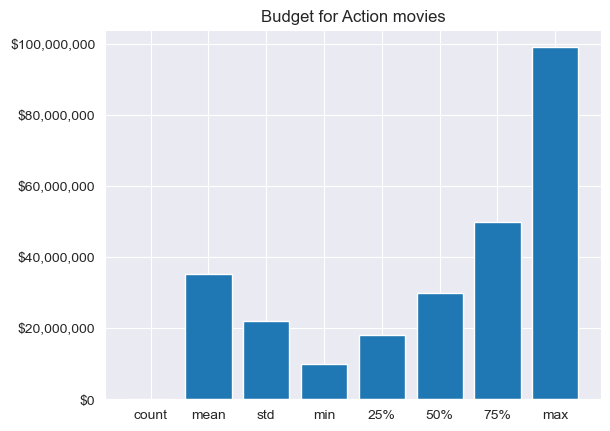

In [57]:
#plotting the data
fig,ax=plt.subplots()
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
#plotting budget stats
ax.bar(x=budget_stats.index,height=budget_stats['production_budget']);
ax.set_title('Budget for Action movies');

**75% percent of the budgets for *Action* movies are around $50 million, similar to *Adventure* movies that we analyzed earlier. This could work in the studio's favor allowing them to be be able to produce both genre of movies without having to compromise on budgets.**

### How have *Action* movies performed over the years?

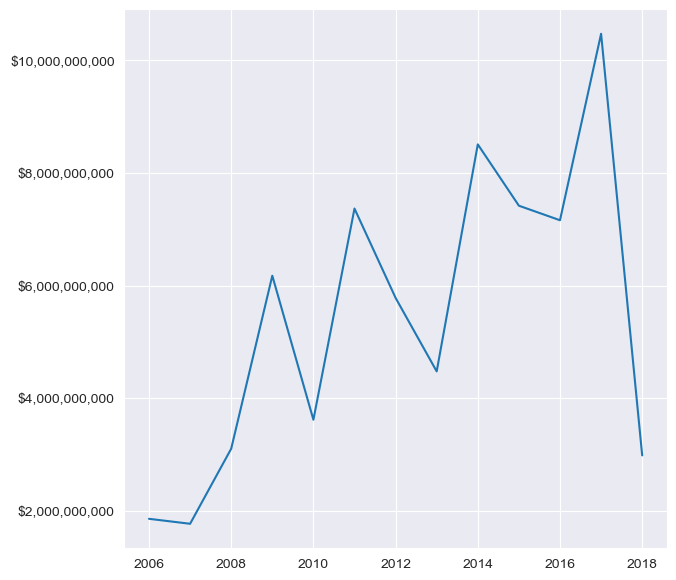

In [58]:
#creating a seperate df
action = df_ratings[df_ratings['genre']=='Action']
#rouping the data
action_years = action.groupby('production_year').sum()
#plotting the data
fig,ax=plt.subplots(figsize=(7,7))
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
#plot the data
ax.plot(action_years['total_revenue']);

Discounting the last 2 years, we can see a see-saw pattern in *Action* movie returns requiring a more in-depth study for the causes.

### Conclusion

1. *Action* is the most popular genre in the PG-13 category
2. Median budget is approximately $30 million.

## Limitations

1. A lack of good quality data is the main hindrance for the analysis. The returns could be further whittled down to see if  certain actors/actresses, directors, producers etc. provided more returns than others.
2. Post-release data i.e. DVD/Blu-ray sales could have provided some insight.
3. Since the advent of streaming platforms, audience preference of movie consumption has also changed considerably and there is a glaring lack of data about performance on streaming platforms.

# Overall Conclusions
1. The studio should be looking at producing *Adventure* and *Action* movies catering to *PG* and *PG-13* audiences respectively.
2. Budgets for each genre can be expected to be around $50 million.
3. Although there are other factors in play, production budgets play a significant role in box-office returns i.e. bigger budgets may result in higher returns.

# Appendix

Another way to collect data is by scraping web sites.

Let's use one of  Python's popular libraries for web scraping: *Beautiful Soup*

In [59]:
import requests
from bs4 import BeautifulSoup

[Box Office Mojo](https://www.boxofficemojo.com/year/world/?ref_=bo_nb_in_tab) provides revenue information that we can scrape for analysis.

In [60]:
#making a request to retrieve the page
html_page = requests.get('https://www.boxofficemojo.com/year/world/2023/')

#pass the page contents into BeautifulSoup for parsing
soup = BeautifulSoup(html_page.content,'lxml')

Now that we have made a request and have the required data, we now to parse the data to extract the information that we need.
Looking thru the HTML code, we can see that the data is stored in a tabular format and can be located using the specific class:

In [61]:
#locating the table based on the class
table = soup.find(class_= 'a-section imdb-scroll-table-inner')

From the table, we can extract the headers to use as the column names for our dataframe:

In [62]:
#getting the headers of the table using the 'th' tag
head = table.find_all('th')

#iterating thru head to get the text 
headers = []
for h in head:
    headers.append(h.text)

headers

['Rank', 'Release Group\n', 'Worldwide', 'Domestic', '%', 'Foreign', '%']

In [63]:
#renaming 'Release Group'
headers[1] = 'Release Group'

In [64]:
#setting the table headers as column names
df = pd.DataFrame(columns=headers)
df.head()

,Rank,Release Group,Worldwide,Domestic,%,Foreign,%


Next, we have to go thru each row in the table using the *tr* tag and pull the info using the *td* tag and populate our df. The following block of code does just that:

In [65]:
#getting all the table rows using the tr tag
rows = table.find_all('tr')

#have to iterate thru the 'tr' tags to get the the table data which is stored in the 'td' tag
for i in rows[1:]:
    #looking for table data using the 'td' tag
    data = i.find_all('td')
    #again, you have to iterate thru the td tags and get only the text to populate the df
    row = [tr.text for tr in data]
    #appending the data to the df
    l = len(df)
    df.loc[l] = row

Let's check the df:

In [66]:
df

,Rank,Release Group,Worldwide,Domestic,%,Foreign,%
0,1,The Super Mario Bros. Movie,"$1,339,633,793","$573,633,860",42.8%,"$765,999,933",57.2%
1,2,Guardians of the Galaxy Vol. 3,"$838,313,750","$356,057,705",42.5%,"$482,256,045",57.5%
2,3,Fast X,"$699,395,886","$145,689,435",20.8%,"$553,706,451",79.2%
3,4,Spider-Man: Across the Spider-Verse,"$613,728,882","$346,018,107",56.4%,"$267,710,775",43.6%
4,5,The Little Mermaid,"$527,549,654","$283,804,896",53.8%,"$243,744,758",46.2%
...,...,...,...,...,...,...,...
195,196,Rascal Does Not Dream of a Sister Venturing Out,"$2,073,714",-,-,"$2,073,714",100%
196,197,Como Dios manda,"$1,974,071",-,-,"$1,974,071",100%
197,198,Illegal Hayatlar,"$1,945,286",-,-,"$1,945,286",100%
198,199,Des mains en or,"$1,856,691",-,-,"$1,856,691",100%


If we take a look at the url link again: https://www.boxofficemojo.com/year/world/2023/, we can see that the webage points to the year 2023. This points to the options of selecting different years and thereby more data.

Let's check to see how many years are there

The dropdown option for years is stored under the *option* tag

In [67]:
#getting the option tag
options = soup.find_all('option')

#creating an empty list to store the year values
years = []

#looping thru to get the text alone
for opt in options:
    years.append(opt.text)

print(f'Latest year is {years[0]}')
print(f'Oldest year is {years[-1]}')

Latest year is 2023
Oldest year is 1977


We can see that data spans from 1977-2023, giving us a tremendous amount of data for us to analyze!

Thus we can see how scraping websites can be useful for collecting data.T There are some ethical considerations when it comes to scraping data and so care must be taken when using this method. A better alternative to scraping would be to make API calls.